In [1]:
# imports
import numpy as np
import pandas as pd
import os, yaml
osp = os.path
from glob import glob
from importlib import reload
import matplotlib.pyplot as plt
from pathlib import Path
import dill as pickle

import torch
nn = torch.nn
F = nn.functional
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.rcParams['figure.dpi'] = 300

In [2]:
import args as args_module
from data import dataloader, adni, mrigenie, transforms as data_tx
from analysis import analyze, inception, tables, figures
import jobs as job_mgmt
import util
import monai.transforms as mtr
rescale_clip = mtr.ScaleIntensityRangePercentiles(lower=1, upper=99, b_min=0, b_max=255, clip=True, dtype=np.uint8)
rescale_noclip = mtr.ScaleIntensityRangePercentiles(lower=0, upper=100, b_min=0, b_max=255, clip=True, dtype=np.uint8)
rescale_float = mtr.ScaleIntensityRangePercentiles(lower=1, upper=99, b_min=0, b_max=1, clip=True)
rescale_clipbot = mtr.ScaleIntensityRangePercentiles(lower=1, upper=100, b_min=0, b_max=255, clip=True, dtype=np.uint8)
pad_adni = mtr.Pad([(0,0),(10,10)])
ANALYSIS_DIR = osp.expanduser("~/code/sitgan/temp")
%matplotlib inline

# interactive

In [ ]:
reload(figures);

In [ ]:
job_mgmt.delete_job("ditstar")
#job_mgmt.rename_job("raw_a_ipg", "fine_raw_a_ipg")

In [92]:
for job in ["dms_1",]:
    figures.save_sample_outputs_for_job(job, slurm=True, overwrite=True)

In [ ]:
figures.save_sample_outputs_for_job("raw_a_rgae", slurm=True, overwrite=True)

In [ ]:
analyze.collect_metrics_for_jobs("raw_a_rgae", slurm=True, overwrite=True)

In [42]:
df = tables.get_results_table()
#df.drop(df.index, inplace=True)
#df.drop("sparse field",axis=1, inplace=True)

In [44]:
jobs = df[df["model type"] == "StarGAN"].index.values

In [46]:
for ix in range(0,20,4):
    analyze.collect_metrics_for_jobs(jobs[ix:ix+4], slurm=True, overwrite=True)

In [4]:
jobs = ["raw_m_caae"]
for ix in range(0,len(jobs),4):
    analyze.get_image_fidelity_metrics_for_jobs(jobs[ix:ix+4], slurm=True, overwrite="all")

In [276]:
tables.save_results_table(df)

In [ ]:
#_,val_datalist = pickle.load(open(osp.join(ANALYSIS_DIR, "2d_adni.dat"), "rb"))
ages = [dp["attributes"][3] for dp in val_datalist]
ages = np.array(ages)
plt.hist(ages)

In [ ]:
out = pickle.load(open(osp.expanduser(
    "~/code/sitgan/analysis/slurm/mrig_traj/89049_submitted.pkl"), "rb"))

In [ ]:
args = job_mgmt.get_job_args("dit_m_star")

In [ ]:
#args = args_module.args_from_file(osp.expanduser("~/code/sitgan/configs/adni.yaml"))
#dataloader.get_dataloaders(args, overwrite=True)

In [ ]:
#inception.fine_tune_regressor_on_dataset("2D MRI-GENIE FLAIR", slurm=True, n_iters=1000)
#inception.fine_tune_regressor_on_dataset("2D ADNI T1", slurm=True, n_iters=1000)

In [ ]:
inception.get_incv3_activations_of_ds("2D MRI-GENIE FLAIR", tuned=True, overwrite=True, slurm=True)

In [3]:
jobs = tables.get_all_mrigenie_jobs_in_table()
#jobs = tables.get_all_adni_jobs_in_table()
#analyze.get_regressor_metrics_for_job(jobs, slurm=True, overwrite=True)

In [ ]:
analyze.get_image_fidelity_metrics_for_jobs(("dit_m_rgae", "raw_m_rgae"),
                        slurm=True, overwrite="all")

In [ ]:
analyze.get_regressor_metrics_for_job("raw_m_star", slurm=True, overwrite="all")

_,age_std = np.load(osp.join(ANALYSIS_DIR, "adni_normalizations.npy"))[0]
arr = np.load(osp.expanduser("~/code/sitgan/temp/incv3/adni_age.npy"))
arr.mean() * age_std, arr.std() * age_std

_,age_std = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[0]
arr = np.load(osp.expanduser("~/code/sitgan/temp/incv3/mrigenie_age.npy"))
arr.mean() * age_std, arr.std() * age_std

# Tables

## ADNI raw vs SIT

In [4]:
jobs = ["raw_a_rgae", "dit_a_rgae", "raw_a_caae", "dit_a_caae",
        "raw_a_ipg", "dit_a_ipg", "raw_a_star", "das_1"]
df = tables.get_results_table()
subtable = df.loc[jobs]

def plus_minus_format(mean, std, n_decimals=2, bold=False):
    if bold:
        return (r'$\bm{{{0:.%df}}}$\scriptsize$\bm{{\pm {1:.%df}}}$'%(n_decimals, n_decimals)).format(mean, std)        
    else:
        return (r'${0:.%df}$\scriptsize$\pm {1:.%df}$'%(n_decimals, n_decimals)).format(mean, std)

def print_row(name, row, bold=()):
    field1 = plus_minus_format(row["RMSE"], row["RMSE STD"], bold=1 in bold)
    field2 = plus_minus_format(row["SSIM"], row["SSIM STD"], bold=2 in bold)
    field3 = plus_minus_format(row["age mean error"], row["age error STD"], bold=3 in bold)
    print(" & ".join([name, field1, field2, field3]) + r" \\")

In [5]:
print_row(r"\blue{RGAE}", subtable.iloc[0])
print_row(r"\blue{+ SIT (ours)}", subtable.iloc[1], bold=(1,2,3))
print(r"\hline")
print_row(r"CAAE \cite{caae}", subtable.iloc[2], bold=[1,])
print_row(r"\blue{+ SIT (ours)}", subtable.iloc[3], bold=[1,2,3])
print(r"\hline")
print_row(r"IPGAN \cite{xia2019learning}", subtable.iloc[4], bold=[])
print_row(r"\blue{+ SIT (ours)}", subtable.iloc[5], bold=(1,2,3))
print(r"\hline")
print_row(r"StarGAN \cite{stargan}", subtable.iloc[6], bold=[])
print_row(r"+ SIT (ours)", subtable.iloc[7], bold=[1,2,3])

\blue{RGAE} & $0.26$\scriptsize$\pm 0.02$ & $0.36$\scriptsize$\pm 0.02$ & $10.26$\scriptsize$\pm 7.44$ \\
\blue{+ SIT (ours)} & $\bm{0.13}$\scriptsize$\bm{\pm 0.03}$ & $\bm{0.13}$\scriptsize$\bm{\pm 0.04}$ & $\bm{-2.45}$\scriptsize$\bm{\pm 6.50}$ \\
\hline
CAAE \cite{caae} & $\bm{0.14}$\scriptsize$\bm{\pm 0.02}$ & $0.16$\scriptsize$\pm 0.04$ & $-4.31$\scriptsize$\pm 5.61$ \\
\blue{+ SIT (ours)} & $\bm{0.14}$\scriptsize$\bm{\pm 0.03}$ & $\bm{0.15}$\scriptsize$\bm{\pm 0.04}$ & $\bm{0.81}$\scriptsize$\bm{\pm 7.24}$ \\
\hline
IPGAN \cite{xia2019learning} & $0.13$\scriptsize$\pm 0.02$ & $0.16$\scriptsize$\pm 0.04$ & $1.90$\scriptsize$\pm 6.12$ \\
\blue{+ SIT (ours)} & $\bm{0.12}$\scriptsize$\bm{\pm 0.03}$ & $\bm{0.13}$\scriptsize$\bm{\pm 0.04}$ & $\bm{-1.45}$\scriptsize$\bm{\pm 5.62}$ \\
\hline
StarGAN \cite{stargan} & $0.16$\scriptsize$\pm 0.03$ & $0.17$\scriptsize$\pm 0.04$ & $0.82$\scriptsize$\pm 6.54$ \\
+ SIT (ours) & $\bm{0.11}$\scriptsize$\bm{\pm 0.03}$ & $\bm{0.13}$\scriptsize$\bm{\

jobs = ["raw_a_rgae", "dit_a_rgae", "raw_a_caae", "dit_a_caae",
        "raw_a_ipg", "dit_a_ipg", "raw_a_star", "dit_a_star"]
analyze.get_image_matching_metrics_for_jobs(jobs, slurm=True, overwrite=True)

## ADNI G outputs

In [17]:
jobs = ["raw_a_star", "it_a_star", "st_a_star", "dt_a_star", "sit_a_star", "das_1"]
df = tables.get_results_table()
subtable = df.loc[jobs]

def plus_minus_format(mean, std, n_decimals=2, bold=False):
    if bold:
        return (r'$\bm{{{0:.%df}}}$\scriptsize$\bm{{\pm {1:.%df}}}$'%(n_decimals, n_decimals)).format(mean, std)        
    else:
        return (r'${0:.%df}$\scriptsize$\pm {1:.%df}$'%(n_decimals, n_decimals)).format(mean, std)

def print_row(name, row, bold=()):
    field1 = plus_minus_format(row["RMSE"], row["RMSE STD"], bold=1 in bold)
    field2 = plus_minus_format(row["SSIM"], row["SSIM STD"], bold=2 in bold)
    field3 = plus_minus_format(row["age mean error"], row["age error STD"], bold=3 in bold)
    print(" & ".join([name, field1, field2, field3]) + r" \\")

In [18]:
print_row("Base", subtable.iloc[0])
print_row("IT", subtable.iloc[1])
print_row("ST-Disp", subtable.iloc[2], bold=[1])
print_row("ST-Diff", subtable.iloc[3], bold=[1,2])
print_row("SIT-Disp", subtable.iloc[4], bold=[])
print_row("SIT-Diff", subtable.iloc[5], bold=[1,3])

Base & $0.16$\scriptsize$\pm 0.03$ & $0.17$\scriptsize$\pm 0.04$ & $0.82$\scriptsize$\pm 6.54$ \\
IT & $0.12$\scriptsize$\pm 0.03$ & $0.15$\scriptsize$\pm 0.04$ & $-0.43$\scriptsize$\pm 7.57$ \\
ST-Disp & $\bm{0.11}$\scriptsize$\bm{\pm 0.03}$ & $0.12$\scriptsize$\pm 0.04$ & $-1.92$\scriptsize$\pm 5.59$ \\
ST-Diff & $\bm{0.11}$\scriptsize$\bm{\pm 0.03}$ & $\bm{0.11}$\scriptsize$\bm{\pm 0.05}$ & $-1.80$\scriptsize$\pm 6.06$ \\
SIT-Disp & $0.15$\scriptsize$\pm 0.03$ & $0.18$\scriptsize$\pm 0.04$ & $0.68$\scriptsize$\pm 6.33$ \\
SIT-Diff & $\bm{0.11}$\scriptsize$\bm{\pm 0.03}$ & $0.13$\scriptsize$\pm 0.04$ & $\bm{-0.40}$\scriptsize$\bm{\pm 6.84}$ \\


## MRIG raw vs SIT

In [11]:
jobs = ["raw_m_rgae", "dit_m_rgae", "raw_m_caae", "dit_m_caae",
        "raw_m_ipg", "dit_m_ipg", "raw_m_star", "dms_1"]
df = tables.get_results_table()
subtable = df.loc[jobs]

def latex_format(value, n_decimals=2, bold=False):
    if bold:
        return (r'$\bm{{{0:.%df}}}$'%n_decimals).format(value)        
    else:
        return (r'${0:.%df}$'%n_decimals).format(value)
def plus_minus_format(mean, std, n_decimals=2, bold=False):
    if bold:
        return (r'$\bm{{{0:.%df}}}$\scriptsize$\bm{{\pm {1:.%df}}}$'%(n_decimals, n_decimals)).format(mean, std)        
    else:
        return (r'${0:.%df}$\scriptsize$\pm {1:.%df}$'%(n_decimals, n_decimals)).format(mean, std)

def print_row(name, row, bold=()):
    field1 = latex_format(row["FID_tuned"], bold=1 in bold)
    field2 = latex_format(row["F_{1/8}"], bold=2 in bold)
    field3 = latex_format(row["F_8"], bold=3 in bold)
    field4 = plus_minus_format(row["age mean error"], row["age error STD"], bold=4 in bold)
    print(" & ".join([name, field1, field2, field3, field4]) + r" \\")

In [12]:
print_row(r"\blue{RGAE}", subtable.iloc[0], bold=[3,4])
print_row(r"\blue{+ SIT (ours)}", subtable.iloc[1], bold=(1,2,3,))
print(r"\hline")
print_row(r"CAAE \cite{caae}", subtable.iloc[2])
print_row(r"\blue{+ SIT (ours)}", subtable.iloc[3], bold=(1,2,3,4))
print(r"\hline")
print_row(r"IPGAN \cite{xia2019learning}", subtable.iloc[4], bold=[])
print_row(r"\blue{+ SIT (ours)}", subtable.iloc[5], bold=(1,2,3,4))
print(r"\hline")
print_row(r"StarGAN \cite{stargan}", subtable.iloc[6])
print_row(r"+ SIT (ours)", subtable.iloc[7], bold=(1,2,3,4))

\blue{RGAE} & $54.49$ & $0.00$ & $\bm{0.00}$ & $\bm{4.13}$\scriptsize$\bm{\pm 14.75}$ \\
\blue{+ SIT (ours)} & $\bm{40.92}$ & $\bm{0.01}$ & $\bm{0.00}$ & $5.71$\scriptsize$\pm 13.00$ \\
\hline
CAAE \cite{caae} & $18.32$ & $0.10$ & $0.12$ & $4.08$\scriptsize$\pm 10.74$ \\
\blue{+ SIT (ours)} & $\bm{4.06}$ & $\bm{0.80}$ & $\bm{0.88}$ & $\bm{0.83}$\scriptsize$\bm{\pm 10.66}$ \\
\hline
IPGAN \cite{xia2019learning} & $11.05$ & $0.14$ & $0.26$ & $4.06$\scriptsize$\pm 9.96$ \\
\blue{+ SIT (ours)} & $\bm{2.86}$ & $\bm{0.81}$ & $\bm{0.95}$ & $\bm{2.70}$\scriptsize$\bm{\pm 9.50}$ \\
\hline
StarGAN \cite{stargan} & $22.77$ & $0.09$ & $0.30$ & $3.10$\scriptsize$\pm 13.21$ \\
+ SIT (ours) & $\bm{2.07}$ & $\bm{0.90}$ & $\bm{0.97}$ & $\bm{1.97}$\scriptsize$\bm{\pm 12.28}$ \\


jobs = ["raw_m_rgae", "dit_m_rgae", "raw_m_caae", "dit_m_caae",
        "raw_m_ipg", "dit_m_ipg", "raw_m_star", "dit_m_star",
        "it_m_star", "st_m_star", "dt_m_star", "sit_m_star"]
analyze.get_image_fidelity_metrics_for_jobs(jobs, slurm=True, overwrite=True)

## MRIG G outputs

In [16]:
jobs = ["raw_m_star", "it_m_star", "st_m_star", "dt_m_star", "sit_m_star", "dms_1"]
df = tables.get_results_table()
subtable = df.loc[jobs]

def latex_format(value, n_decimals=2, bold=False):
    if bold:
        return (r'$\bm{{{0:.%df}}}$'%n_decimals).format(value)        
    else:
        return (r'${0:.%df}$'%n_decimals).format(value)
def plus_minus_format(mean, std, n_decimals=2, bold=False):
    if bold:
        return (r'$\bm{{{0:.%df}}}$\scriptsize$\bm{{\pm {1:.%df}}}$'%(n_decimals, n_decimals)).format(mean, std)        
    else:
        return (r'${0:.%df}$\scriptsize$\pm {1:.%df}$'%(n_decimals, n_decimals)).format(mean, std)

def print_row(name, row, bold=()):
    field1 = latex_format(row["FID_tuned"], bold=1 in bold)
    field2 = latex_format(row["F_{1/8}"], bold=2 in bold)
    field3 = latex_format(row["F_8"], bold=3 in bold)
    field4 = plus_minus_format(row["age mean error"], row["age error STD"], bold=4 in bold)
    print(" & ".join([name, field1, field2, field3, field4]) + r" \\")

In [17]:
print_row("Base", subtable.iloc[0])
print_row("IT", subtable.iloc[1], bold=[1,2,3])
print_row("ST-Disp", subtable.iloc[2])
print_row("ST-Diff", subtable.iloc[3])
print_row("SIT-Disp", subtable.iloc[4], bold=[2])
print_row("SIT-Diff", subtable.iloc[5], bold=[4])

Base & $22.77$ & $0.09$ & $0.30$ & $3.10$\scriptsize$\pm 13.21$ \\
IT & $\bm{0.85}$ & $\bm{0.98}$ & $\bm{0.98}$ & $2.67$\scriptsize$\pm 11.71$ \\
ST-Disp & $2.61$ & $0.82$ & $0.97$ & $6.18$\scriptsize$\pm 11.94$ \\
ST-Diff & $5.50$ & $0.53$ & $0.92$ & $3.02$\scriptsize$\pm 10.40$ \\
SIT-Disp & $1.14$ & $\bm{0.98}$ & $0.95$ & $2.44$\scriptsize$\pm 11.71$ \\
SIT-Diff & $2.07$ & $0.90$ & $0.97$ & $\bm{1.97}$\scriptsize$\bm{\pm 12.28}$ \\


## line searches (supplement)

analyze.get_image_fidelity_metrics_for_jobs(["dms_2","dms_1","dms_0","dms_-1","dms_-2"],
            slurm=True, overwrite=True)

In [13]:
jobs = ["das_-2", "das_-1", "das_0", "das_1", "das_2", "dt_a_star"]
df = tables.get_results_table()
subtable = df.loc[jobs]

def plus_minus_format(mean, std, n_decimals=2, bold=False):
    if bold:
        return (r'$\bm{{{0:.%df}}}$\scriptsize$\bm{{\pm {1:.%df}}}$'%(n_decimals, n_decimals)).format(mean, std)        
    else:
        return (r'${0:.%df}$\scriptsize$\pm {1:.%df}$'%(n_decimals, n_decimals)).format(mean, std)

def print_row(name, row, bold=()):
    field1 = plus_minus_format(row["RMSE"], row["RMSE STD"], bold=1 in bold)
    field2 = plus_minus_format(row["SSIM"], row["SSIM STD"], bold=2 in bold)
    field3 = plus_minus_format(row["age mean error"], row["age error STD"], bold=3 in bold)
    print(" & ".join([name, field1, field2, field3]) + r" \\")

In [ ]:
print_row("0.01", subtable.iloc[0], bold=[3])
print_row("0.1", subtable.iloc[1], bold=[])
print_row("1", subtable.iloc[2], bold=[])
print_row("10", subtable.iloc[3], bold=[1])
print_row("100", subtable.iloc[4], bold=(1,2))
print_row(r"\infty", subtable.iloc[5], bold=(1,2))

In [18]:
jobs = ["dms_-2","dms_-1","dms_0","dms_1","dms_2", "dt_m_star"]
df = tables.get_results_table()
subtable = df.loc[jobs]

def latex_format(value, n_decimals=2, bold=False):
    if bold:
        return (r'$\bm{{{0:.%df}}}$'%n_decimals).format(value)        
    else:
        return (r'${0:.%df}$'%n_decimals).format(value)
def plus_minus_format(mean, std, n_decimals=2, bold=False):
    if bold:
        return (r'$\bm{{{0:.%df}}}$\scriptsize$\bm{{\pm {1:.%df}}}$'%(n_decimals, n_decimals)).format(mean, std)        
    else:
        return (r'${0:.%df}$\scriptsize$\pm {1:.%df}$'%(n_decimals, n_decimals)).format(mean, std)

def print_row(name, row, bold=()):
    field1 = latex_format(row["FID_tuned"], bold=1 in bold)
    field2 = latex_format(row["F_{1/8}"], bold=2 in bold)
    field3 = latex_format(row["F_8"], bold=3 in bold)
    field4 = plus_minus_format(row["age mean error"], row["age error STD"], bold=4 in bold)
    print(" & ".join([name, field1, field2, field3, field4]) + r" \\")

In [20]:
print_row("0.01", subtable.iloc[0], bold=[1,2,3])
print_row("0.1", subtable.iloc[1], bold=[2])
print_row("1", subtable.iloc[2])
print_row("10", subtable.iloc[3], bold=[4])
print_row("100", subtable.iloc[4], bold=[3])
print_row(r"\infty", subtable.iloc[5])

0.01 & $\bm{0.84}$ & $\bm{0.97}$ & $\bm{0.98}$ & $4.15$\scriptsize$\pm 12.05$ \\
0.1 & $1.58$ & $\bm{0.97}$ & $0.96$ & $2.22$\scriptsize$\pm 11.99$ \\
1 & $1.41$ & $0.94$ & $0.97$ & $3.17$\scriptsize$\pm 12.42$ \\
10 & $2.07$ & $0.90$ & $0.97$ & $\bm{1.97}$\scriptsize$\bm{\pm 12.28}$ \\
100 & $2.47$ & $0.78$ & $\bm{0.97}$ & $4.23$\scriptsize$\pm 11.69$ \\
\infty & $5.50$ & $0.53$ & $0.92$ & $3.02$\scriptsize$\pm 10.40$ \\


# Figures

### ADNI vs. ground truth

In [236]:
adni_index_map = {"131_S_0441": [3,6],
    "137_S_0994": [3,6], "131_S_1389": [3,5],
                  "136_S_0695": [3,5],
                 "127_S_0260":(5,-1),}
#                   "136_S_0195": []}

In [257]:
age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "adni_normalizations.npy"))[0]
dx_mean,dx_scale = np.load(osp.join(ANALYSIS_DIR, "adni_normalizations.npy"))[1]
subject_id = "127_S_0260"#"137_S_0994"
job = "raw_a_ipg"
n_attr = 4
models, args = job_mgmt.get_job_model_and_args(job)
_, transforms = data_tx.get_transforms(args)
model_type = args["network"]["type"]
dps, T = adni.get_all_timepoints_for_subject(subject_id)
dps = transforms(dps)
base_age = round(dps[0]["attributes"][0].item() * age_scale + age_mean)
base_dx = round(dps[0]["attributes"][1].item() * dx_scale + dx_mean)
print("base age:",base_age, "| base dx:", base_dx)
ixs = adni_index_map[subject_id]
ages = [round(dps[ix]["attributes"][0].item() * age_scale + age_mean) for ix in ixs]
print("predicted ages:",ages)

base age: 79 | base dx: -1
predicted ages: [83, 87]


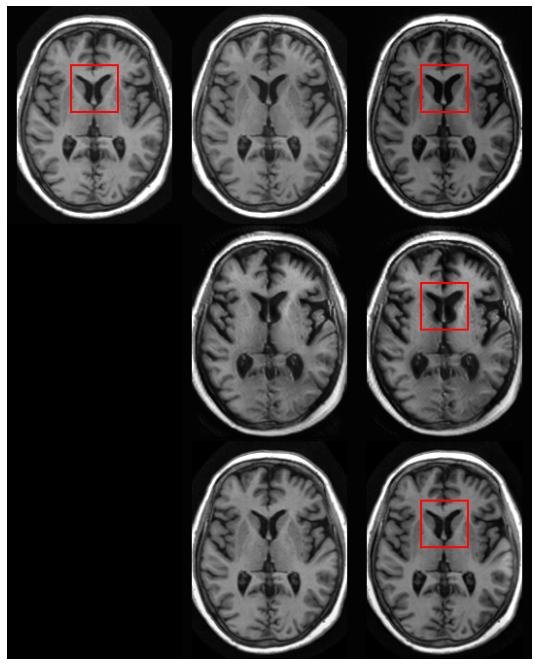

In [258]:
#
G=models["G"]
dY, X_gt = [], []
X_0 = dps[0]["image"].cuda().unsqueeze(0).tile(len(ixs),1,1,1)
for i in ixs:
    y = torch.stack([(T[i]-T[0])/age_scale, *[torch.zeros_like(T[0])]*(n_attr-1)], 0)
    dY.append(y)
    X_gt.append(dps[i]["image"])
X_gt = torch.stack(X_gt,0)
dY = torch.stack(dY,0).cuda()
with torch.no_grad():
    if False:
        attr_gt = dps[0]["attributes"].cuda()
        attr_gt = torch.where(torch.isnan(attr_gt), torch.randn_like(attr_gt), attr_gt).unsqueeze(0).tile(dY.size(0),1)
        X_est = G(X_0, y=attr_gt, dy=dY)
    else:
        X_est = G(X_0, dY)
outputs = {"X_0": pad_adni(dps[0]["image"].squeeze()),
    "X_gt": pad_adni(X_gt.squeeze(1)), "X_est": pad_adni(X_est.cpu().squeeze(1))}

top = torch.cat((outputs["X_0"], *outputs["X_gt"]), dim=1)
mid = torch.cat((outputs["X_0"], *outputs["X_est"]), dim=1)

job = "das_1" #"dit_a_ipg" #"das_1"#
models, args = job_mgmt.get_job_model_and_args(job)
model_type = args["network"]["type"]
G=models["G"]
with torch.no_grad():
    X_est = G(X_0, dY)
X_0 = pad_adni(dps[0]["image"].squeeze())
outputs = {"X_0": X_0, "X_est": pad_adni(X_est.cpu().squeeze(1))}
bot = torch.cat((outputs["X_0"], *outputs["X_est"]), dim=1)

#top sulci
# y1,y2=15,65
# x1,x2=75,120
#upper ventricles
y1,y2=60,110
x1,x2=65,115
#right sulci
# y1,y2=55,130
# x1,x2=110,155
lines = [(slice(y1,y2), slice(x1,x1+2)), (slice(y1,y2), slice(x2-2,x2)),
        (slice(y1,y1+2), slice(x1,x2)), (slice(y2-2,y2), slice(x1,x2))]
top = top.unsqueeze(-1).tile(1,1,3)
mid = mid.unsqueeze(-1).tile(1,1,3)
bot = bot.unsqueeze(-1).tile(1,1,3)
topright = top[:,-X_0.size(1):]
midright = mid[:,-X_0.size(1):]
botright = bot[:,-X_0.size(1):]
vmax = max(top.max(), mid.max(), bot.max())
for line in lines:
    top[(*line,0)].fill_(vmax)
    top[(*line,slice(1,3))].zero_()
    topright[(*line,0)].fill_(vmax)
    topright[(*line,slice(1,3))].zero_()
    midright[(*line,0)].fill_(vmax)
    midright[(*line,slice(1,3))].zero_()
    botright[(*line,0)].fill_(vmax)
    botright[(*line,slice(1,3))].zero_()
full = torch.cat((top, mid, bot), dim=0)
full = rescale_clip(full)
full[X_0.size(0):, :X_0.size(1)].zero_();

plt.rcParams["figure.figsize"] = (17.0, 12.0)
plt.imshow(full); plt.axis('off');

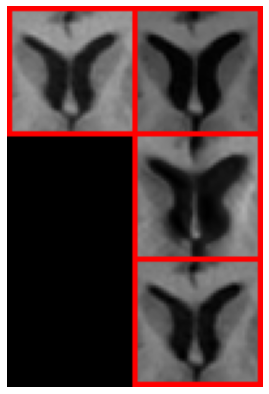

In [259]:
crop = [slice(y1,y2), slice(x1,x2)]
blank = torch.zeros_like(topright[slice(y1+2,y2), slice(x1,x2-2)])
top_crops = torch.cat((top[crop[0], slice(x1,x2-2)], topright[crop[0], crop[1]]), dim=1)
mid_crops = torch.cat((blank, midright[slice(y1+2,y2), crop[1]]), dim=1)
bot_crops = torch.cat((blank, botright[slice(y1+2,y2), crop[1]]), dim=1)
crops = torch.cat((top_crops, mid_crops, bot_crops), dim=0)
crops = rescale_clip(crops)
plt.rcParams["figure.figsize"] = (9.0, 7.0)
plt.imshow(crops); plt.axis('off');

### MRIG age, NIHSS

In [ ]:
# find appropriate test subject
age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[0]
nihss_mean,nihss_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[1]
path = osp.join(ANALYSIS_DIR, "2d_mrigenie.dat")
_, val_datalist = pickle.load(open(path, "rb"))
test_ids = []
for dp in val_datalist:
    if np.isnan(dp["attributes"][1].item()):
        continue
    age = round(dp["attributes"][0].item() * age_scale + age_mean)
    if age < 60 or age > 75:
        continue
    dp_id = dp["ID"]
    if dp_id.endswith("_0"):
        test_ids.append(dp_id[:dp_id.rfind("_")])
test_ids

In [25]:
# age
job = "dms_1"
age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[0]
nihss_mean,nihss_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[1]
subject_id = "005_T2_FLAIR_TRA_0_2300000230"
dp = mrigenie.get_midslice_for_subject(subject_id)
base_age = round(dp["attributes"][0].item() * age_scale + age_mean)
base_nihss = round(dp["attributes"][1].item() * nihss_scale + nihss_mean)
print("base age:",base_age, "| base NIHSS:", base_nihss)
models, args = job_mgmt.get_job_model_and_args(job)
model_type = args["network"]["type"]
G=models["G"]
_, transforms = data_tx.get_transforms(args)
dp = transforms([dp])[0]

base age: 76 | base NIHSS: 5


In [26]:
gt_ix = 2
n_attr = 2
age_diffs = torch.cat((torch.arange(-20,-4,5), torch.arange(5,21,5)))[4-gt_ix:8-gt_ix]
dY = age_diffs.cuda().unsqueeze(1).tile(n_attr) / age_scale
dY[:,1].zero_()
X_0 = dp["image"].cuda().unsqueeze(0).tile(4,1,1,1)
with torch.no_grad():
    X_est = G(X_0, dY)
X_est = X_est.cpu().squeeze(1)
X_0 = dp["image"].squeeze()

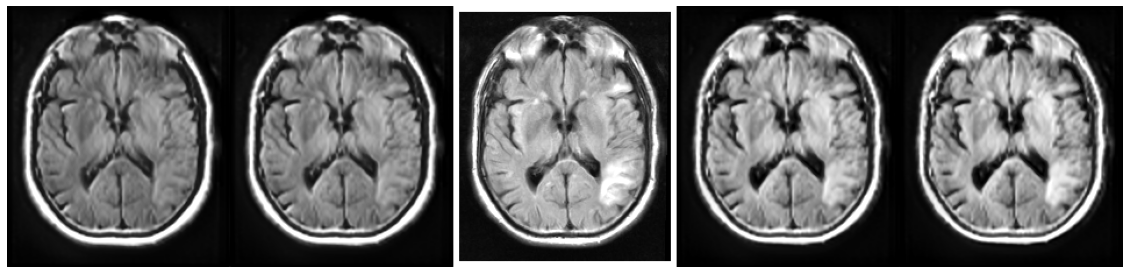

In [27]:
border = 5
X_0[:border] = X_0[-border:] = X_0[:,:border] = X_0[:,-border:] = X_0.max()
img = torch.cat((*X_est[:2], X_0, *X_est[2:]), dim=1)
img = rescale_noclip(img)
plt.rcParams["figure.figsize"] = (20.0, 16.0)
plt.imshow(img, cmap="gray"); plt.axis('off');

In [ ]:
# find appropriate test subject
nihss_mean,nihss_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[1]
path = osp.join(ANALYSIS_DIR, "2d_mrigenie.dat")
_, val_datalist = pickle.load(open(path, "rb"))
test_ids = []
for dp in val_datalist:
    if np.isnan(dp["attributes"][1].item()):
        continue
    if round(dp["attributes"][1].item() * nihss_scale + nihss_mean) < 10:
        continue
    dp_id = dp["ID"]
    if dp_id.endswith("_0"):
        test_ids.append(dp_id[:dp_id.rfind("_")])

In [ ]:
sorted(test_ids)

In [14]:
# NIHSS
job = "dms_1"#"dms_1"
n_attr = 2
age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[0]
nihss_mean,nihss_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[1]
subject_id = "004_FLAIR_AXIAL_0_360326855"
dp = mrigenie.get_midslice_for_subject(subject_id)
base_age = round(dp["attributes"][0].item() * age_scale + age_mean)
base_nihss = round(dp["attributes"][1].item() * nihss_scale + nihss_mean)
print("base age:",base_age, "| base NIHSS:", base_nihss)
models, args = job_mgmt.get_job_model_and_args(job)
model_type = args["network"]["type"]
G=models["G"]
_, transforms = data_tx.get_transforms(args)
dp = transforms([dp])[0]

base age: 87 | base NIHSS: 10


In [15]:
gt_ix = 2
nihss_diffs = torch.cat((torch.arange(-20,-4,5), torch.arange(5,21,5)))[4-gt_ix:8-gt_ix]
dY = nihss_diffs.cuda().unsqueeze(1).tile(n_attr) / nihss_scale
dY[:,0].zero_()
dY[:,2:].zero_()
X_0 = dp["image"].cuda().unsqueeze(0).tile(4,1,1,1)
with torch.no_grad():
    X_est = G(X_0, dY)
X_est = X_est.cpu().squeeze(1)
X_0 = dp["image"].squeeze()

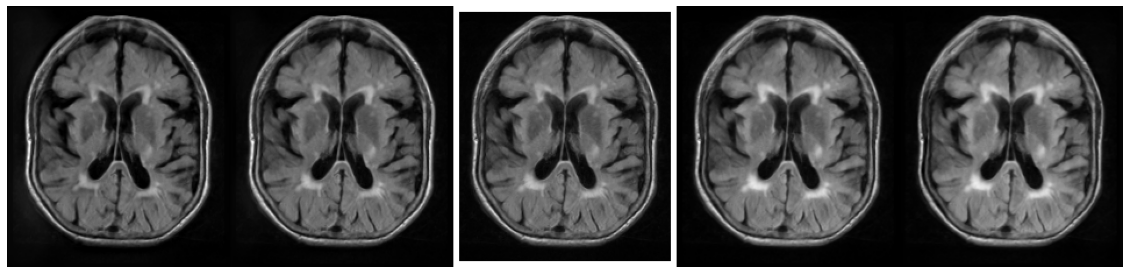

In [16]:
border = 5
X_0[:border] = X_0[-border:] = X_0[:,:border] = X_0[:,-border:] = X_0.max()
img = torch.cat((*X_est[:2], X_0, *X_est[2:]), dim=1)
img = rescale_clip(img)
plt.rcParams["figure.figsize"] = (20.0, 16.0)
plt.imshow(img, cmap="gray"); plt.axis('off');

### MRIG raw vs SIT

In [6]:
# MRIG age
subject_id = "015_AXFLAIR_0_333441525"#"004_FLAIR_TRA_P2_0_1600000275"
jobs = ["raw_m_rgae", "raw_m_caae", "raw_m_ipg", "raw_m_star",
        "dit_m_rgae", "dit_m_caae", "dit_m_ipg", "dms_1"]

age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[0]
dp = mrigenie.get_midslice_for_subject(subject_id)
base_age = round(dp["attributes"][0].item() * age_scale + age_mean)
print("base age:", base_age)
args = job_mgmt.get_job_args(jobs[0])
_, transforms = data_tx.get_transforms(args)
dp = transforms([dp])[0]

base age: 67


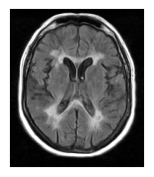

In [11]:
output_imgs = []
dY = torch.zeros_like(dp["attributes"]).unsqueeze(0).cuda()
dY[:,0] = 15/age_scale
X_0 = dp["image"].cuda().unsqueeze(0)
for job in jobs:
    models, args = job_mgmt.get_job_model_and_args(job)
    model_type = args["network"]["type"]
    G=models["G"]
    with torch.no_grad():
        if False:
            attr_gt = dp["attributes"].cuda()
            attr_gt = torch.where(torch.isnan(attr_gt), torch.randn_like(attr_gt), attr_gt).unsqueeze(0)
            X_est = G(X_0, y=attr_gt, dy=dY)
        else:
            X_est = G(X_0, dY)
    X_est = X_est.cpu().squeeze()
    output_imgs.append(X_est)
plt.rcParams["figure.figsize"] = (4.0, 3.0)
X_0 = X_0.cpu().squeeze()
border = 4
X_0[:border] = X_0[:,:border] = X_0[-border:] = X_0[:,-border:] = 1
plt.imshow(X_0, cmap="gray"); plt.axis('off');

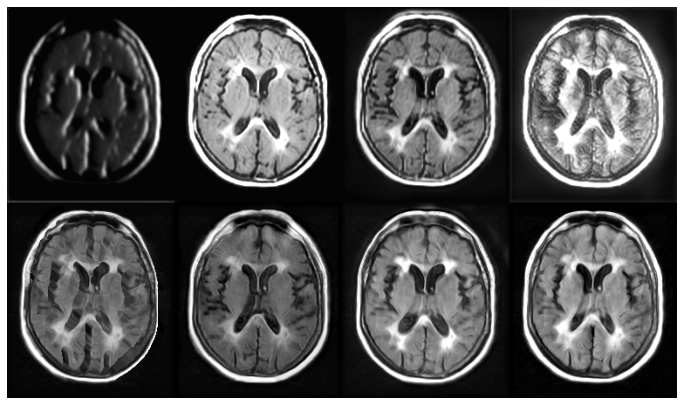

In [12]:
top = torch.cat(output_imgs[:4], dim=1)
bot = torch.cat(output_imgs[4:], dim=1)
img = torch.cat((top, bot), dim=0)
img = rescale_clip(img)
plt.rcParams["figure.figsize"] = (12.0, 8.0)
plt.imshow(img, cmap="gray"); plt.axis('off');

### MRIG G outputs

In [120]:
# MRIG age
subject_id = "005_AX_FLAIR_T2_0_2000000815"
jobs = ["raw_m_star", "st_m_star", "sit_m_star",
        "it_m_star", "dt_m_star", "dms_1"]

age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[0]
dp = mrigenie.get_midslice_for_subject(subject_id)
base_age = round(dp["attributes"][0].item() * age_scale + age_mean)
print("base age:", base_age)
args = job_mgmt.get_job_args(jobs[0])
_, transforms = data_tx.get_transforms(args)
dp = transforms([dp])[0]

base age: 59


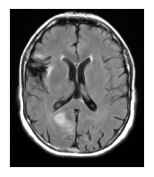

In [122]:
output_imgs = []
dY = torch.zeros_like(dp["attributes"]).unsqueeze(0).cuda()
dY[:,0] = 25/age_scale
X_0 = dp["image"].cuda().unsqueeze(0)
for job in jobs:
    models, args = job_mgmt.get_job_model_and_args(job)
    model_type = args["network"]["type"]
    G=models["G"]
    with torch.no_grad():
        if False:
            attr_gt = dp["attributes"].cuda()
            attr_gt = torch.where(torch.isnan(attr_gt), torch.randn_like(attr_gt), attr_gt).unsqueeze(0)
            X_est = G(X_0, y=attr_gt, dy=dY)
        else:
            X_est = G(X_0, dY)
    X_est = X_est.cpu().squeeze()
    output_imgs.append(X_est)
plt.rcParams["figure.figsize"] = (4.0, 3.0)
X_0 = X_0.cpu().squeeze()
border = 4
X_0[:border] = X_0[:,:border] = X_0[-border:] = X_0[:,-border:] = 1
plt.imshow(X_0, cmap="gray"); plt.axis('off');

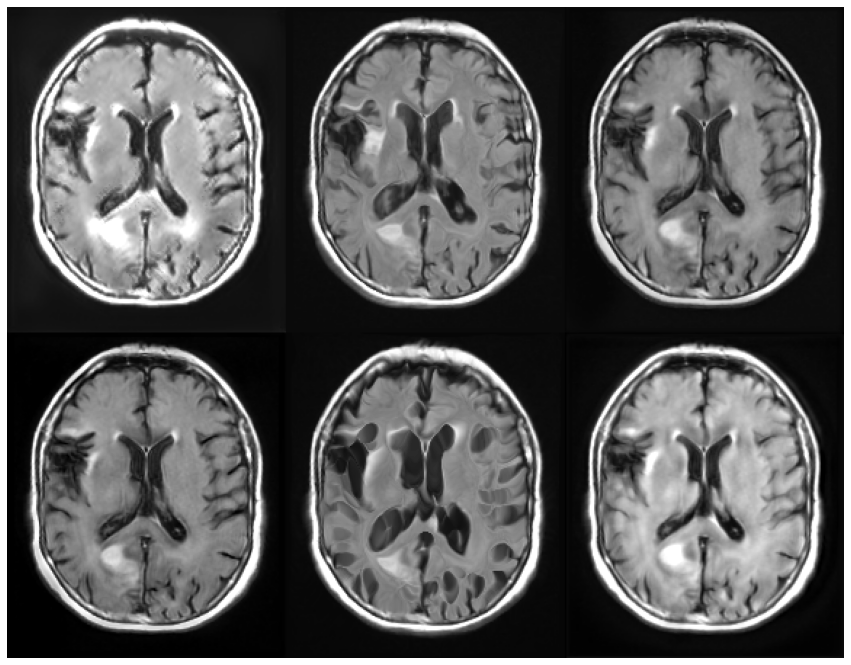

In [123]:
top = torch.cat(output_imgs[:3], dim=1)
bot = torch.cat(output_imgs[3:], dim=1)
top = rescale_float(top)
img = torch.cat((top, bot), dim=0)
img = rescale_clip(img)
plt.rcParams["figure.figsize"] = (13.0, 10.0)
plt.imshow(img, cmap="gray"); plt.axis('off');

### ADNI raw vs SIT (appendix)¶

In [ ]:
131_S_0441_48029_7',
 '131_S_0441_86106_7',
 '131_S_0441_107925_7',
 '131_S_0441_151204_7',
 '131_S_0441_204879_7',
 '131_S_0441_297867_7',
 '131_S_0441_376953_7',
 '131_S_0441_377763_7

In [11]:
jobs = ["raw_a_rgae", "raw_a_caae", "raw_a_ipg", "raw_a_star",
        "dit_a_rgae", "dit_a_caae", "dit_a_ipg", "das_1"]
series_id = "131_S_0441_48029_7"

age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "adni_normalizations.npy"))[0]
dp = adni.get_midslice_for_series(series_id)
base_age = round(dp["attributes"][0].item() * age_scale + age_mean)
print("base age:", base_age)
args = job_mgmt.get_job_args(jobs[0])
_, transforms = data_tx.get_transforms(args)
dp = transforms([dp])[0]

base age: 73


/data/vision/polina/users/clintonw/anaconda3/envs/cuda11/lib/python3.10/site-packages/monai-0.8.0+108.gc2018cf6-py3.10.egg/monai/networks/blocks/warp.py:66: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")


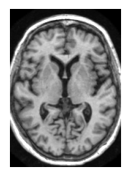

In [12]:
output_imgs = []
dY = torch.zeros_like(dp["attributes"]).unsqueeze(0).cuda()
dY[:,0] = 10/age_scale
X_0 = dp["image"].cuda().unsqueeze(0)
for job in jobs:
    models, args = job_mgmt.get_job_model_and_args(job)
    model_type = args["network"]["type"]
    G=models["G"]
    with torch.no_grad():
        X_est = G(X_0, dY)
    X_est = X_est.cpu().squeeze()
    output_imgs.append(X_est)
output_imgs = [pad_adni(i) for i in output_imgs]
plt.rcParams["figure.figsize"] = (4.0, 3.0)
X_0 = X_0.cpu().squeeze()
X_0 = rescale_noclip(X_0)
border = 4
X_0[:border] = X_0[:,:border] = X_0[-border:] = X_0[:,-border:] = 255
plt.imshow(X_0, cmap="gray"); plt.axis('off');

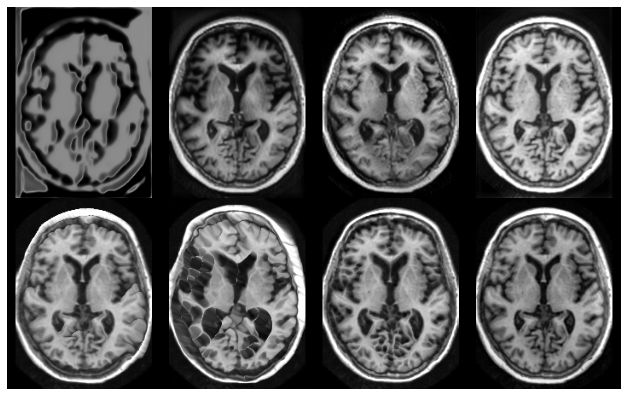

In [13]:
top = torch.cat(output_imgs[:4], dim=1)
bot = torch.cat(output_imgs[4:], dim=1)
img = torch.cat((top, bot), dim=0)
img = rescale_clip(img)
plt.rcParams["figure.figsize"] = (11.0, 8.0)
plt.imshow(img, cmap="gray"); plt.axis('off');

### ADNI G outputs (appendix)

In [63]:
jobs = ["raw_a_star", "st_a_star", "sit_a_star",
        "it_a_star", "dt_a_star", "das_1"]
series_id = "137_S_0800_274717"

age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "adni_normalizations.npy"))[0]
dp = adni.get_midslice_for_series(series_id)
base_age = round(dp["attributes"][0].item() * age_scale + age_mean)
print("base age:", base_age)
args = job_mgmt.get_job_args(jobs[0])
_, transforms = data_tx.get_transforms(args)
dp = transforms([dp])[0]

base age: 79


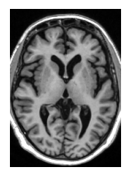

In [64]:
output_imgs = []
dY = torch.zeros_like(dp["attributes"]).unsqueeze(0).cuda()
dY[:,0] = -10/age_scale
X_0 = dp["image"].cuda().unsqueeze(0)
for job in jobs:
    models, args = job_mgmt.get_job_model_and_args(job)
    model_type = args["network"]["type"]
    G=models["G"]
    with torch.no_grad():
        X_est = G(X_0, dY)
    X_est = X_est.cpu().squeeze()
    output_imgs.append(X_est)
plt.rcParams["figure.figsize"] = (4.0, 3.0)
X_0 = X_0.cpu().squeeze()
border = 4
X_0[:border] = X_0[:,:border] = X_0[-border:] = X_0[:,-border:] = 1
plt.imshow(X_0, cmap="gray"); plt.axis('off');

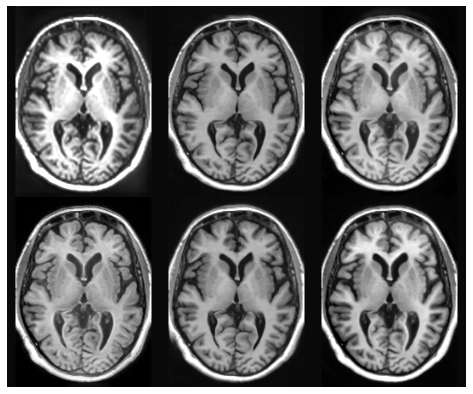

In [65]:
output_imgs = [pad_adni(i) for i in output_imgs]
top = torch.cat(output_imgs[:3], dim=1)
bot = torch.cat(output_imgs[3:], dim=1)
img = torch.cat((top, bot), dim=0)
img = rescale_clip(img)
plt.rcParams["figure.figsize"] = (10.0, 7.0)
plt.imshow(img, cmap="gray"); plt.axis('off');

### MRIG line search (appendix)

In [79]:
# MRIG age
subject_id = "004_FLAIR_TRA_P2_0_1600000275"
jobs = ["dms_-2", "dms_-1", "dms_0", "dms_1", "dms_2"]

age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[0]
dp = mrigenie.get_midslice_for_subject(subject_id)
base_age = round(dp["attributes"][0].item() * age_scale + age_mean)
print("base age:", base_age)
args = job_mgmt.get_job_args(jobs[0])
_, transforms = data_tx.get_transforms(args)
dp = transforms([dp])[0]

base age: 63


In [ ]:
output_imgs = []
dY = torch.zeros_like(dp["attributes"]).unsqueeze(0).cuda()
dY[:,0] = 20/age_scale
X_0 = dp["image"].cuda().unsqueeze(0)
for job in jobs:
    models, args = job_mgmt.get_job_model_and_args(job)
    model_type = args["network"]["type"]
    G=models["G"]
    with torch.no_grad():
        if False:
            attr_gt = dp["attributes"].cuda()
            attr_gt = torch.where(torch.isnan(attr_gt), torch.randn_like(attr_gt), attr_gt).unsqueeze(0)
            X_est = G(X_0, y=attr_gt, dy=dY)
        else:
            X_est = G(X_0, dY)
    X_est = X_est.cpu().squeeze()
    output_imgs.append(X_est)
plt.rcParams["figure.figsize"] = (5.0, 4.0)
X_0 = rescale_float(X_0.cpu().squeeze())
border = 4
X_0[:border] = X_0[:,:border] = X_0[-border:] = X_0[:,-border:] = 1
plt.imshow(X_0, cmap="gray"); plt.axis('off');

In [ ]:
img = torch.cat(output_imgs, dim=1)
img = rescale_clip(img)
plt.rcParams["figure.figsize"] = (15.0, 12.0)
plt.imshow(img, cmap="gray"); plt.axis('off');

### Disentangle figure

In [ ]:
# path = osp.join(ANALYSIS_DIR, "2d_adni.dat")
# _, val_datalist = pickle.load(open(path, "rb"))

# dps = []
# for dp in val_datalist:
#     if dp["ID"].startswith("137_S_0994") and dp["ID"].endswith("_7"):
#         print(dp["ID"])

In [32]:
series_ids = [dp["ID"] for dp in adni.get_all_timepoints_for_subject("131_S_0441")[0]]
series_ids

['131_S_0441_48029_7',
 '131_S_0441_86106_7',
 '131_S_0441_107925_7',
 '131_S_0441_151204_7',
 '131_S_0441_204879_7',
 '131_S_0441_297867_7',
 '131_S_0441_376953_7',
 '131_S_0441_377763_7']

In [186]:
# ADNI
series_id = "141_S_0915_349714"
job = "das_1"
age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "adni_normalizations.npy"))[0]
dp = adni.get_midslice_for_series(series_id)
base_age = round(dp["attributes"][0].item() * age_scale + age_mean)
print("base age:", base_age)
models, args = job_mgmt.get_job_model_and_args(job)
model_type = args["network"]["type"]
_, transforms = data_tx.get_transforms(args)
dp = transforms([dp])[0]
G=models["G"]

base age: 86


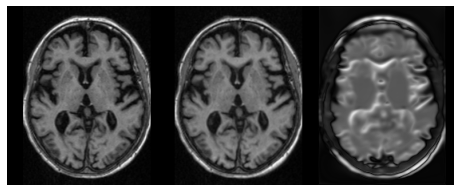

In [187]:
output_imgs = []
dY = torch.zeros_like(dp["attributes"]).unsqueeze(0).cuda()
dY[:,0] = -10/age_scale
X_0 = dp["image"].cuda().unsqueeze(0)
with torch.no_grad():
    if False:
        attr_gt = dp["attributes"].cuda()
        attr_gt = torch.where(torch.isnan(attr_gt), torch.randn_like(attr_gt), attr_gt).unsqueeze(0)
        X_est, transforms = G(X_0, y=attr_gt, dy=dY, return_transforms=True)
    else:
        X_est, transforms = G(X_0, dY, return_transforms=True)
X_est = rescale_noclip(X_est.cpu().squeeze())
X_0 = rescale_noclip(X_0.cpu().squeeze());
flow = rescale_noclip((transforms[0,1:]).pow(2).sum(0).sqrt().cpu())
X_0 = pad_adni(X_0)
# border = 4
# X_0[:border] = X_0[:,:border] = X_0[-border:] = X_0[:,-border:] = 255
img = torch.cat([pad_adni(X_0), pad_adni(X_est), pad_adni(flow)], dim=1)
plt.rcParams["figure.figsize"] = (8.0, 4.0)
plt.imshow(img, cmap="gray"); plt.axis('off');

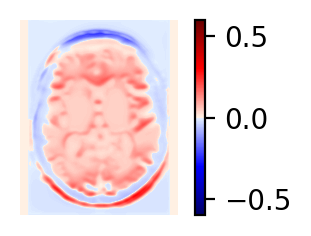

In [191]:
#reload(figures)
plt.rcParams["figure.figsize"] = (2.0, 1.0)
diffs = transforms[0,0].cpu()
figures.add_colorplot(pad_adni(diffs), abs_max=.6)

In [193]:
# MRIG
subject_id = "010_FLAIR_FSE_8_AXIAL_0_600035360"
job = "dms_1bk"
age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "mrigenie_normalizations.npy"))[0]
dp = mrigenie.get_midslice_for_subject(subject_id)
base_age = round(dp["attributes"][0].item() * age_scale + age_mean)
print("base age:", base_age)
models, args = job_mgmt.get_job_model_and_args(job)
model_type = args["network"]["type"]
_, transforms = data_tx.get_transforms(args)
dp = transforms([dp])[0]
G=models["G"]

base age: 66


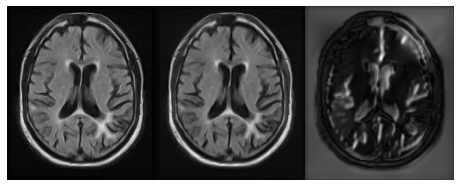

In [194]:
output_imgs = []
dY = torch.zeros_like(dp["attributes"]).unsqueeze(0).cuda()
dY[:,0] = 10/age_scale
X_0 = dp["image"].cuda().unsqueeze(0)
with torch.no_grad():
    if False:
        attr_gt = dp["attributes"].cuda()
        attr_gt = torch.where(torch.isnan(attr_gt), torch.randn_like(attr_gt), attr_gt).unsqueeze(0)
        X_est, transforms = G(X_0, y=attr_gt, dy=dY, return_transforms=True)
    else:
        X_est, transforms = G(X_0, dY, return_transforms=True)
X_est = rescale_noclip(X_est.cpu().squeeze())
X_0 = rescale_noclip(X_0.cpu().squeeze());
flow = rescale_noclip((transforms[0,1:]).pow(2).sum(0).sqrt().cpu())

img = torch.cat([X_0, X_est, flow], dim=1)
plt.rcParams["figure.figsize"] = (8.0, 4.0)
plt.imshow(img, cmap="gray"); plt.axis('off');

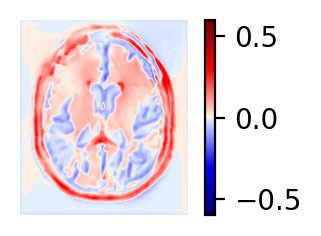

In [195]:
plt.rcParams["figure.figsize"] = (2.0, 1.0)
diffs = transforms[0,0].cpu()
figures.add_colorplot(diffs, abs_max=.6)

In [ ]:
jobs = ["constrained_dit_m_star"]
imgs = figures.compile_trajectory_for_jobs_and_subject(jobs, subject_id)
plt.imshow(imgs); plt.axis('off');

In [ ]:
# ADNI
plt.rcParams["figure.figsize"] = (20.0, 16.0)
jobs = ["raw_a_star", "a_dit2"]#jobs = ["dit_a_star", "sit_a_star"]
subject_id = "137_S_0994" #131_S_1389, 136_S_0695, 136_S_0195
imgs = figures.compile_trajectory_for_jobs_and_subject(jobs, subject_id)
plt.imshow(imgs); plt.axis('off');

## ADNI Failure cases (appendix)

In [33]:
test_ids = adni.get_test_subjects_for_adni()
ids = []
for d in test_ids:
    dps, T = adni.get_all_timepoints_for_subject(d)
    dt = T[-1]-T[0]
    if dt>6:
        ids.append(d)
        if len(ids) > 10:
            break

In [46]:
ids = ['126_S_1187', '131_S_0384', '127_S_0112', '127_S_0925']
age_mean,age_scale = np.load(osp.join(ANALYSIS_DIR, "adni_normalizations.npy"))[0]
dx_mean,dx_scale = np.load(osp.join(ANALYSIS_DIR, "adni_normalizations.npy"))[1]
job = "das_1"
n_attr = 4
models, args = job_mgmt.get_job_model_and_args(job)
_, transforms = data_tx.get_transforms(args)
G=models["G"]
X_0,X_gt,X_est = [],[],[]
base_ages = []
out_ages = []
dxs = []
for d in ids:
    dps, T = adni.get_all_timepoints_for_subject(d)
    dps = transforms(dps)
    base_ages.append(dps[0]["attributes"][0] * age_scale + age_mean)
    out_ages.append(dps[-1]["attributes"][0] * age_scale + age_mean)
    dxs.append((dps[0]["attributes"][1] * dx_scale + dx_mean))
    x_0 = dps[0]["image"].cuda().unsqueeze(0)
    dY = torch.stack([(T[-1]-T[0])/age_scale,
              *[torch.zeros_like(T[0])]*(n_attr-1)], 0).unsqueeze(0).cuda()
    with torch.no_grad():
        x_est = G(x_0, dY)
    X_0.append(pad_adni(dps[0]["image"].squeeze()))
    X_gt.append(pad_adni(dps[-1]["image"].squeeze()))
    X_est.append(pad_adni(x_est.cpu().squeeze()))
top = torch.cat(X_0, dim=1)
mid = torch.cat(X_gt, dim=1)
bot = torch.cat(X_est, dim=1)
full = torch.cat((top, mid, bot), dim=0)
full = rescale_clip(full)

['126_S_1187',
 '128_S_0272',
 '127_S_0260',
 '130_S_0969',
 '131_S_0384',
 '128_S_0229',
 '127_S_1032',
 '127_S_0112',
 '129_S_1246',
 '141_S_0717',
 '127_S_0925']

In [ ]:
plt.rcParams["figure.figsize"] = (17.0, 12.0)
plt.imshow(full, cmap="gray"); plt.axis('off');

In [58]:
base_ages, out_ages

([tensor(77.), tensor(80.), tensor(71.), tensor(75.)],
 [tensor(84.), tensor(87.), tensor(79.), tensor(82.)])

# Videos

# Backup

#### rewrite dataset.bin

In [ ]:
paths["GASROS"]["2D npy subdir"]

In [ ]:
data_dir = "/data/vision/polina/scratch/clintonw/datasets/ADNI/2d_t1"
dataset = pickle.load(open(data_dir+"/dataset.bin", "rb"))

In [ ]:
pickle.dump(new_dps, open(data_dir+"/dataset.bin", "wb"))

In [ ]:
dps = dataset["datapoints"]

In [ ]:
pathsss = glob("/data/vision/polina/scratch/clintonw/amadeus/tmp/backups/ds_instance*")

In [ ]:
ix += 1
path =pathsss[ix]
dataset = pickle.load(open(path, "rb"))
print(dataset["name"])

In [ ]:
for dp in new_dps:
    if not osp.exists(data_dir+"/"+dp["ID"]+".npy"):
        print(dp)

In [ ]:
new_dps = []
for dp in dps:
    props = dp.properties
    props.pop("time instantiated", None)
    props.pop("time last seen", None)
    props.pop("time last modified", None)
    props.pop("originating actions", None)
    #props["observations"]["age"] = props["observations"]["Age"]
    if "estimates" not in props:
        pass
    elif len(props["estimates"]) == 0:
        props.pop("estimates", None)
    else:
        print(dp["name"])
    if "pipeline history" not in props:
        pass
    elif len(props["pipeline history"]) == 0:
        props.pop("pipeline history", None)
    else:
        print(dp["name"])
    new_dp = {"ID": dp["name"], **props}
    new_dps.append(new_dp)

In [ ]:
path = osp.expanduser("~/code/sitgan/configs/mrigenie.yaml")
yaml.dump(paths, open(path, "w"))

In [ ]:
paths["full MRI-GENIE"] = osp.join(paths["MRI-GENIE dataset folder"], "full_mri-genie/ds_instance.bin")

In [ ]:
path = osp.join(paths["MRI-GENIE dataset folder"], "2d_mri-genie_flair", "ds_instance.bin")
out = pickle.load(open(path, "rb"))

In [ ]:
ds = {k:out[k] for k in ["datapoints", "variables", "root folder", "training indices", "validation indices"]}

In [ ]:
dps = []
for dp in out["datapoints"]:
    dp["path"] = out["base image path"](dp)
    dps.append({k:dp[k] for k in ["path", "SiGN ID", "Porpoise ID", "GASROS ID", "clinical site", "sequence name", "observations", "slice number", "total slices"]})

In [ ]:
ds["datapoints"] = dps

In [ ]:
with open(osp.join(paths["MRI-GENIE dataset folder"], "2d_mri-genie_flair.ds"), "wb") as f:
    pickle.dump(ds, f)

### Identify artifacts

In [ ]:
# flip
# 002_AXIAL_FLAIR_400001271, 003_FLAIR_AX_0_600057300,
# 004_AXIAL_FLAIR_400001409, 009_AX_FLAIR_T2_400001742,
# 009_AX_T2_FLAIR_PROPELLER_0_400001882,

# delete:
# 003_HUVUD_FLAIR_TRANS_0_1900000003, 003_HUVUD_FLAIR_TRANS_0_1900000007,
# 003_HUVUD_FLAIR_TRANS_0_1900000017, 003_flair_T2_TIRM_TRA_DARK_FLUID_0_1800000035,
# 003_flair_T2_TIRM_TRA_DARK_FLUID_0_1800000456,
# 003_flair_T2_TIRM_TRA_DARK_FLUID_RS_0_1800000559,
# 004_AXIAL_FLAIR_400001188, 004_FLAIR_TRA_P2_1_1600000004_7
# 004_HUVUD_FLAIR_TRANS_0_1900000011, 005_AXIAL_FLAIR_0_100000291,
# 005_AX_FLAIR_T2_0_2000000721, 005_AX_FLAIR_T2_400001858,
# 005_EP2D_TRA_DARK_FLUIDFLAIR_0_100000038, 005_HUVUD_FLAIR_TRANS_0_1900000418,
# 005_T2_FLAIR_TRA_0_2300000094, 006_AX_FLAIR_T2_400001727,
# 007_AX_FLAIR_T2_400000055, 010_FLAIR_FSE_8_AXIAL_0_600051530,
# 012_T2_FLAIR_TRA_0_2300000687, 701_FLAIR_TRA_0_600058080,

In [ ]:
paths["full MRI-GENIE"] = osp.join(paths["MRI-GENIE dataset folder"], "full_mri-genie.bin")

In [ ]:
for dp in ds["datapoints"]:
    if dp["slice number"] == 7:
        img = np.load(dp["path"])
        plt.imsave(osp.join(paths['HOME'], "downloads", "flairs",
                    osp.basename(dp["path"])[:-4])+".png", img, cmap="gray")

In [ ]:
osp.basename(dp["path"])[:-4]

In [ ]:
plt.imshow(img, cmap="gray"); plt.axis('off');

In [ ]:
img_paths = sorted(glob.glob(osp.join(paths['HOME'], "downloads/flairs/*")))
ix = -1

In [ ]:
ix-=4

In [ ]:
ix += 1
path = img_paths[ix]
img1 = plt.imread(path)
ix += 1
path = img_paths[ix]
img2 = plt.imread(path)
ix += 1
path = img_paths[ix]
img3 = plt.imread(path)
img = np.concatenate((img1, img2, img3), axis=1)
plt.imshow(img, cmap="gray"); plt.axis('off');

In [ ]:
img_paths[ix-2]

In [ ]:
plt.imshow(img1, cmap="gray"); plt.axis('off');